# Whole Image Quality Control Report

## Import libraries

In [1]:
suppressPackageStartupMessages(library(dplyr))
suppressPackageStartupMessages(library(ggplot2))
suppressPackageStartupMessages(library(platetools))
suppressPackageStartupMessages(library(stringr))
suppressPackageStartupMessages(library(RColorBrewer))

Warning message:
“package ‘ggplot2’ was built under R version 4.2.3”
Warning message:
“package ‘platetools’ was built under R version 4.2.3”
Warning message:
“package ‘stringr’ was built under R version 4.2.3”
Warning message:
“package ‘RColorBrewer’ was built under R version 4.2.3”


## Set paths and variables

In [2]:
# Paths to CSV files to generate QC report
path_to_outlier_results <- file.path("./qc_results/qc_outliers.csv")
path_to_cp_qc_results <- file.path("./qc_results/localhost231120090001/Image.csv")

# Output path for bar chart
barchart_output_file <- file.path(paste0("./qc_figures/localhost231120090001_fov_per_well_chart.png"))

# Output path for platemap
platemap_output_file <- file.path(paste0("./qc_figures/localhost231120090001_platemap_fov_per_well.png"))

## Load in outlier and quality control results

In [3]:
# Read in CSV files
outlier_df <- read.csv(path_to_outlier_results)
qc_df <- read.csv(path_to_cp_qc_results)

# Add 'Metadata_Well' and 'Metadata_Site' columns using filename from 'FileName_OrigActin'
qc_df <- qc_df %>%
  mutate(Metadata_Well = gsub("_", "", str_extract(FileName_OrigActin, "_([^f]+)")),
         Metadata_Site = str_extract(FileName_OrigActin, "f.{2}"))
         
head(qc_df)

,Channel_OrigActin,Channel_OrigDNA,Channel_OrigER,Channel_OrigMito,Channel_OrigPM,ExecutionTime_01Images,ExecutionTime_02Metadata,ExecutionTime_03NamesAndTypes,ExecutionTime_04Groups,ExecutionTime_05MeasureImageQuality,⋯,URL_OrigER,URL_OrigMito,URL_OrigPM,Width_OrigActin,Width_OrigDNA,Width_OrigER,Width_OrigMito,Width_OrigPM,Metadata_Well,Metadata_Site
,<int>,<int>,<int>,<int>,<int>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,⋯,<chr>,<chr>,<chr>,<int>,<int>,<int>,<int>,<int>,<chr>,<chr>
1,-1,-1,-1,-1,-1,0,0,1.56,0,2.11,⋯,file:/home/jenna/CFReT_data/0.download_data/Images/localhost231120090001/localhost231120090001_B02f00d1.TIF,file:/home/jenna/CFReT_data/0.download_data/Images/localhost231120090001/localhost231120090001_B02f00d3.TIF,file:/home/jenna/CFReT_data/0.download_data/Images/localhost231120090001/localhost231120090001_B02f00d2.TIF,1104,1104,1104,1104,1104,B02,f00
2,-1,-1,-1,-1,-1,0,0,1.08,0,2.05,⋯,file:/home/jenna/CFReT_data/0.download_data/Images/localhost231120090001/localhost231120090001_B02f01d1.TIF,file:/home/jenna/CFReT_data/0.download_data/Images/localhost231120090001/localhost231120090001_B02f01d3.TIF,file:/home/jenna/CFReT_data/0.download_data/Images/localhost231120090001/localhost231120090001_B02f01d2.TIF,1104,1104,1104,1104,1104,B02,f01
3,-1,-1,-1,-1,-1,0,0,0.79,0,2.51,⋯,file:/home/jenna/CFReT_data/0.download_data/Images/localhost231120090001/localhost231120090001_B02f02d1.TIF,file:/home/jenna/CFReT_data/0.download_data/Images/localhost231120090001/localhost231120090001_B02f02d3.TIF,file:/home/jenna/CFReT_data/0.download_data/Images/localhost231120090001/localhost231120090001_B02f02d2.TIF,1104,1104,1104,1104,1104,B02,f02
4,-1,-1,-1,-1,-1,0,0,0.52,0,2.01,⋯,file:/home/jenna/CFReT_data/0.download_data/Images/localhost231120090001/localhost231120090001_B02f03d1.TIF,file:/home/jenna/CFReT_data/0.download_data/Images/localhost231120090001/localhost231120090001_B02f03d3.TIF,file:/home/jenna/CFReT_data/0.download_data/Images/localhost231120090001/localhost231120090001_B02f03d2.TIF,1104,1104,1104,1104,1104,B02,f03
5,-1,-1,-1,-1,-1,0,0,0.60,0,1.97,⋯,file:/home/jenna/CFReT_data/0.download_data/Images/localhost231120090001/localhost231120090001_B02f04d1.TIF,file:/home/jenna/CFReT_data/0.download_data/Images/localhost231120090001/localhost231120090001_B02f04d3.TIF,file:/home/jenna/CFReT_data/0.download_data/Images/localhost231120090001/localhost231120090001_B02f04d2.TIF,1104,1104,1104,1104,1104,B02,f04
6,-1,-1,-1,-1,-1,0,0,0.59,0,1.96,⋯,file:/home/jenna/CFReT_data/0.download_data/Images/localhost231120090001/localhost231120090001_B02f05d1.TIF,file:/home/jenna/CFReT_data/0.download_data/Images/localhost231120090001/localhost231120090001_B02f05d3.TIF,file:/home/jenna/CFReT_data/0.download_data/Images/localhost231120090001/localhost231120090001_B02f05d2.TIF,1104,1104,1104,1104,1104,B02,f05


## Generate data frame removing poor quality sites and counting the number of sites left per well

In [4]:
# Load in platemap and add cell type to include in plate map figure
platemap_df <- read.csv("../metadata/localhost231120090001_platemap.csv")

# Find the number of FOVs that are being removed due to being poor images
unique_combinations <- outlier_df[c('Metadata_Well', 'Metadata_Site')] %>% distinct()
cat("The number of image sets being removed is", nrow(unique_combinations), "out of 960 image sets\n")

# Remove the image sets from the main data frame to generate bar chart
result_df <- anti_join(qc_df, unique_combinations, by = c('Metadata_Well', 'Metadata_Site'))

# Group by 'Metadata_Well' and count the occurrences of 'Metadata_Site'
counts_per_well <- result_df %>% group_by(Metadata_Well) %>% summarise(count = n())

# Select only relevant columns
platemap_subset <- platemap_df[, c("well_position", "cell_type")]

# Add cell type to counts per well
counts_per_well <- merge(counts_per_well, platemap_subset, 
                         by.x = "Metadata_Well", by.y = "well_position", all.x = TRUE)

dim(counts_per_well)
head(counts_per_well)

The number of image sets being removed is 21 out of 960 image sets


[1] 60  3

,Metadata_Well,count,cell_type
,<chr>,<int>,<chr>
1,B02,16,Healthy
2,B03,16,Failing
3,B04,16,Healthy
4,B05,16,Failing
5,B06,16,Healthy
6,B07,14,Failing


## Generate bar chart to show how many FOVs were processed after QC

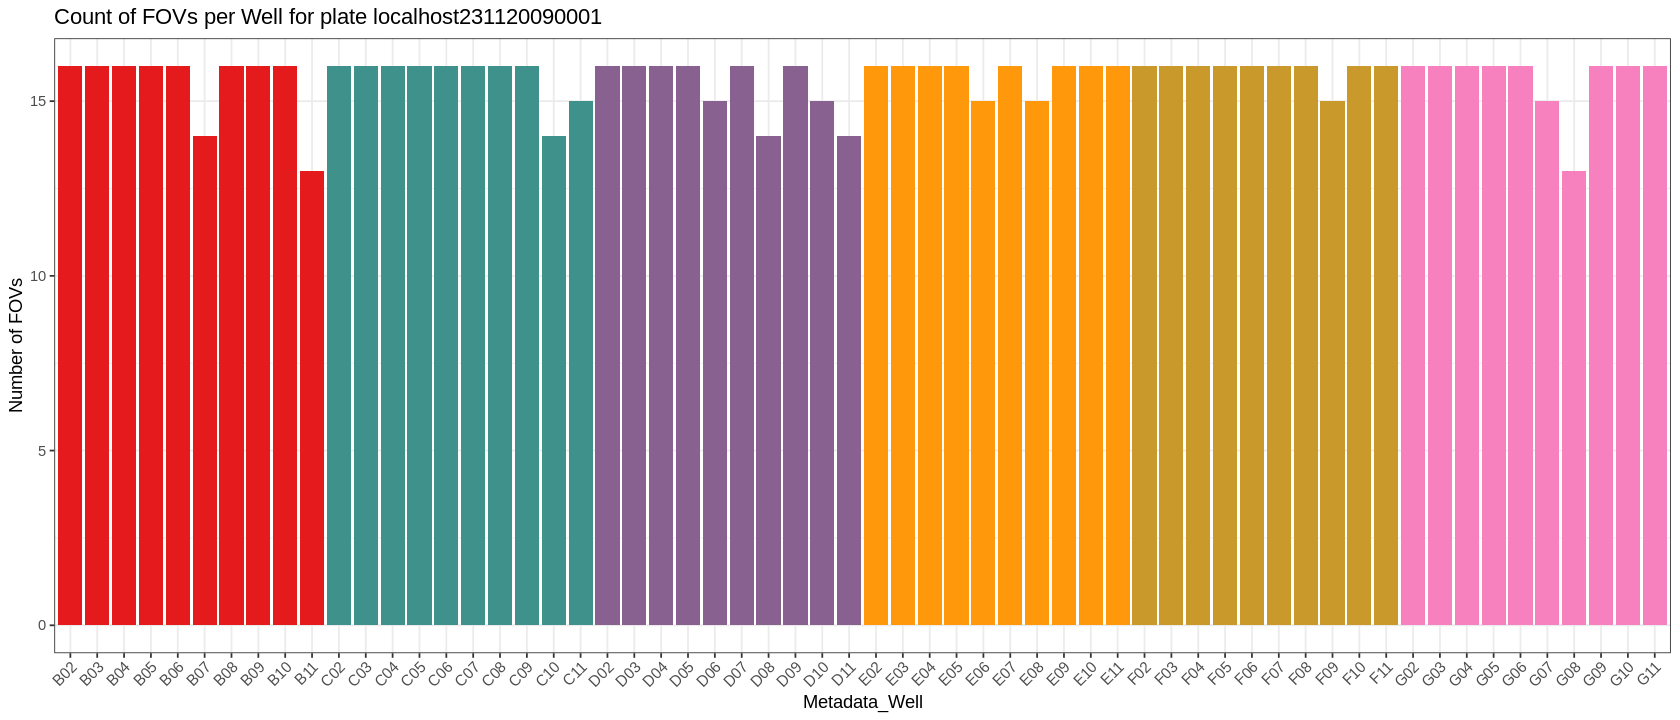

In [5]:
# Extract the first letter from 'Metadata_Well' to create a color palette
unique_starting_letters <- unique(substr(counts_per_well$Metadata_Well, 1, 1))

# Create a color palette based on unique starting letters
color_palette <- colorRampPalette(brewer.pal(8, "Set1"))(length(unique_starting_letters))

# Map each unique starting letter to a color in a named vector
color_dict <- setNames(color_palette, unique_starting_letters)

# Create a new column 'Color' in the data frame based on the starting letter
counts_per_well$Color <- color_dict[substr(counts_per_well$Metadata_Well, 1, 1)]

# Increase the figure size to extend the chart horizontally
options(repr.plot.width=14, repr.plot.height=6)

# Create a bar chart using ggplot2 with the 'Color' column for colors
fov_chart <- ggplot(counts_per_well, aes(x = Metadata_Well, y = count, fill = Color)) +
  geom_bar(stat = 'identity') +
  labs(x = 'Metadata_Well', y = 'Number of FOVs', title = 'Count of FOVs per Well for plate localhost231120090001') +
  scale_fill_identity() +
  theme_bw() +
  theme(axis.text.x = element_text(angle = 45, hjust = 1))

# Save plot to qc_figures
ggsave(
        barchart_output_file,
        fov_chart,
        dpi = 500,
        height = 6,
        width = 10
    )

# Display the plot in the notebook
print(fov_chart)


## Generate plate map to show distribution of FOVs left after QC

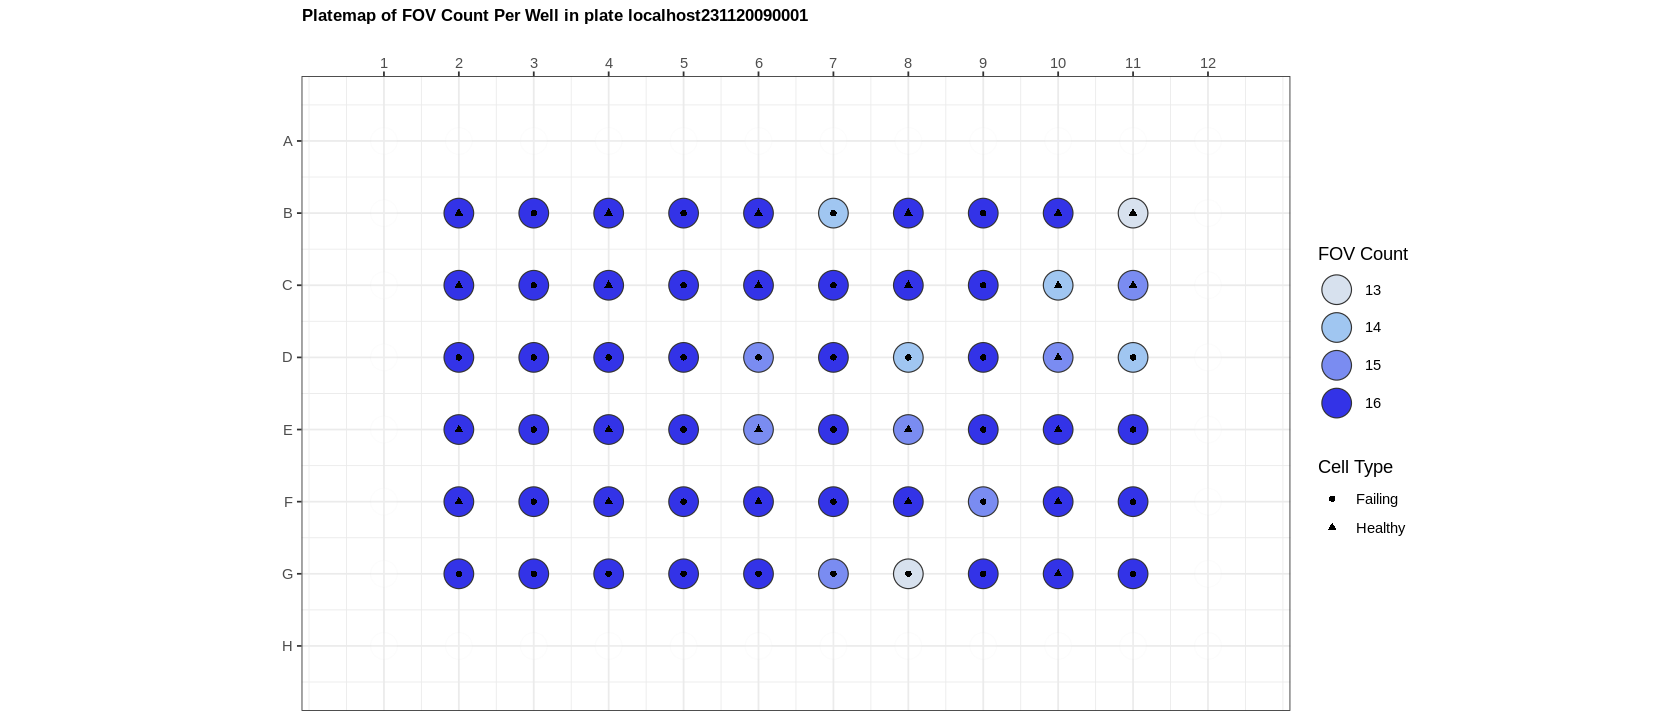

In [12]:
fov_platemap <- platetools::raw_map(
    data = as.character(counts_per_well$count),
    well = counts_per_well$Metadata_Well,
    plate = 96,
    size = 8
    ) +

    ggtitle(paste("Platemap of FOV Count Per Well in plate localhost231120090001")) +
    theme(plot.title = element_text(size = 10, face = "bold")) +
    geom_point(aes(shape = counts_per_well$cell_type)) +
    scale_shape_discrete(name = "Cell Type") +
    scale_fill_manual(
    name = "FOV Count",
    values = c("13" = "#d7e1ee", "14" = "#a0c6f1", "15" = "#7a8cf1", "16" = "#3333e7") # Assign colors manually
  )
    ggsave(
    platemap_output_file,
    fov_platemap,
    dpi = 500,
    height = 3.5,
    width = 6
    )

# Display the plot in the notebook
print(fov_platemap)

In [13]:
# Filter wells with less than 16 FOVs
filtered_counts <- counts_per_well %>% filter(count < 16)

# Group by cell_type and count the occurrences
count_by_cell_type <- filtered_counts %>% group_by(cell_type) %>% summarise(well_count = n())

# View the result
count_by_cell_type

cell_type,well_count
<chr>,<int>
Failing,7
Healthy,6
